In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
slim = tf.contrib.slim

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist= input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
X=tf.placeholder('float',[None,784])
Z=tf.placeholder('float',[None,256])

In [4]:
#encoder
X1      = slim.fully_connected(X,  256, activation_fn=tf.nn.relu)
mu    = slim.fully_connected(X1, 256, activation_fn=tf.nn.relu)
logstd = slim.fully_connected(X1, 256, activation_fn=tf.nn.relu)
#reparameterization
z       = tf.add(mu, tf.multiply(tf.exp(0.5*logstd) , np.random.normal(0,1)))
#decoder
Z       = z
Z1      = slim.fully_connected(Z, 256, activation_fn=tf.nn.relu)
output  = slim.fully_connected(Z1,784, activation_fn=tf.nn.sigmoid)

In [5]:
#loss
log_likelihood = tf.reduce_sum(X*tf.log(output + 1e-9)+(1 - X)*tf.log(1 - output + 1e-9), reduction_indices=1)
KL_term = -0.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)
variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

In [6]:
#training
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
saver = tf.train.Saver()

In [7]:
num_iterations = 100000
recording_interval = 1000
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []
iteration_array = [i*recording_interval for i in range(int(num_iterations/recording_interval))]
for i in range(num_iterations):
    # np.round to make MNIST binary
    x_batch = np.round(mnist.train.next_batch(600,shuffle=True)[0])
    sess.run(optimizer, feed_dict={X: x_batch})
    if (i%recording_interval == 0):
        vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
        print "Iteration: {}, Loss: {}".format(i, vlb_eval)
        variational_lower_bound_array.append(vlb_eval)
        log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
        KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))

Iteration: 0, Loss: -571.823425293
Iteration: 1000, Loss: -556.083618164
Iteration: 2000, Loss: -395.693481445
Iteration: 3000, Loss: -229.137863159
Iteration: 4000, Loss: -217.473678589
Iteration: 5000, Loss: -213.054840088
Iteration: 6000, Loss: -207.154937744
Iteration: 7000, Loss: -206.248321533
Iteration: 8000, Loss: -202.989227295
Iteration: 9000, Loss: -205.625228882
Iteration: 10000, Loss: -202.487518311
Iteration: 11000, Loss: -204.007781982
Iteration: 12000, Loss: -203.912353516
Iteration: 13000, Loss: -203.058609009
Iteration: 14000, Loss: -200.862106323
Iteration: 15000, Loss: -202.221908569
Iteration: 16000, Loss: -195.918640137
Iteration: 17000, Loss: -196.139602661
Iteration: 18000, Loss: -195.984695435
Iteration: 19000, Loss: -193.940628052
Iteration: 20000, Loss: -187.687515259
Iteration: 21000, Loss: -189.905319214
Iteration: 22000, Loss: -187.85244751
Iteration: 23000, Loss: -188.842941284
Iteration: 24000, Loss: -180.129638672
Iteration: 25000, Loss: -184.941207886


Text(0.5,1,'Loss per iteration')

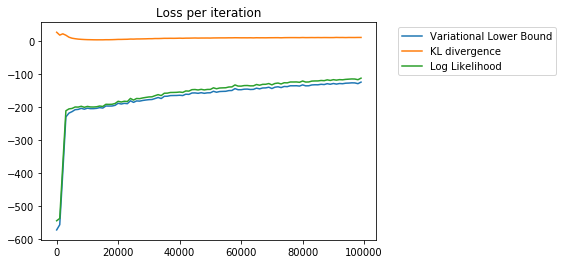

In [8]:
#random plots for coolness
plt.figure()
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')

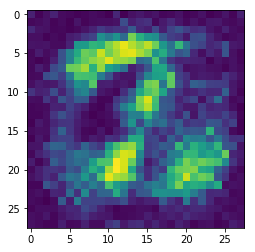

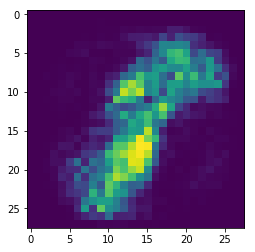

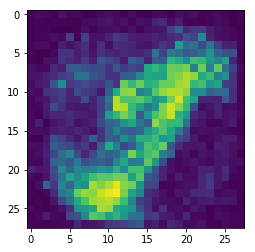

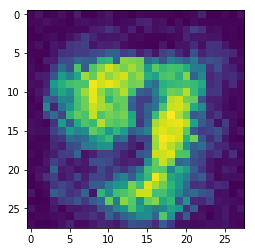

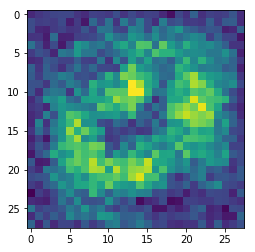

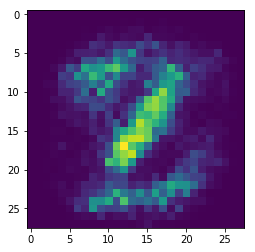

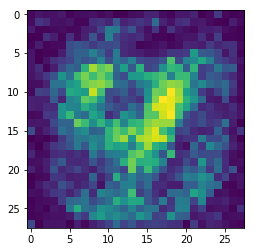

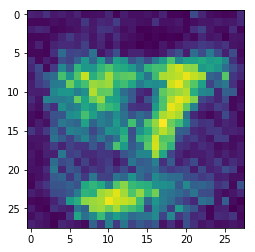

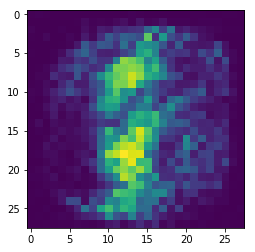

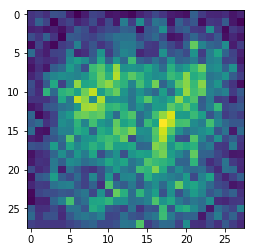

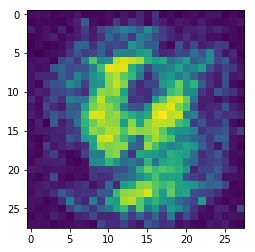

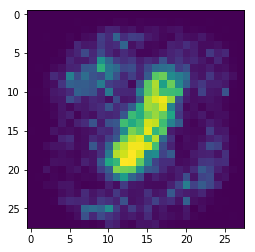

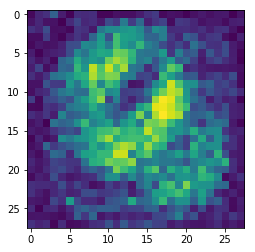

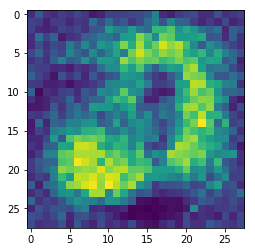

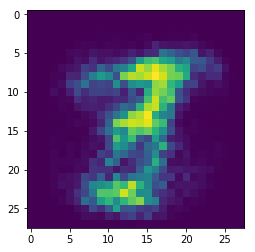

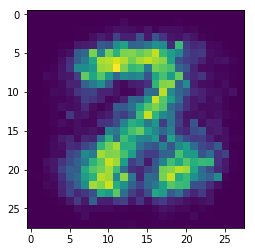

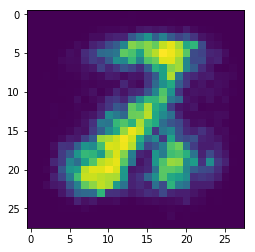

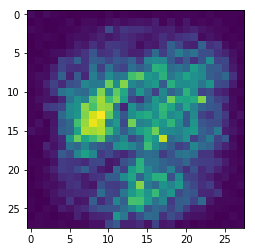

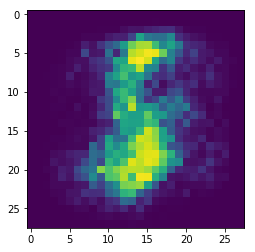

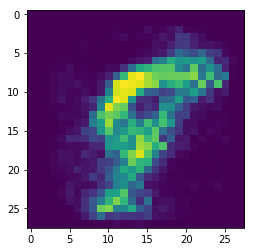

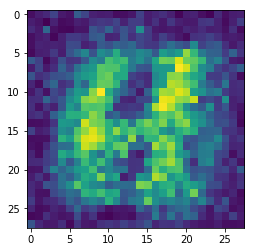

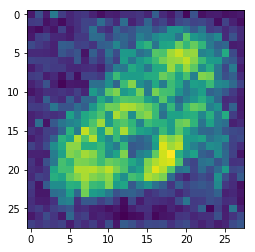

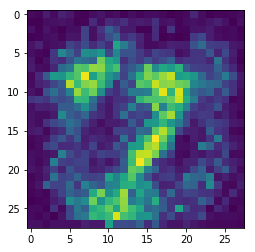

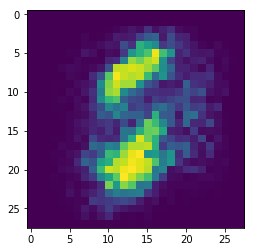

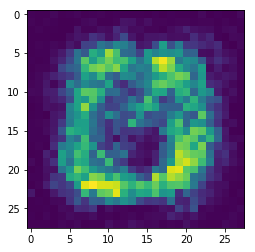

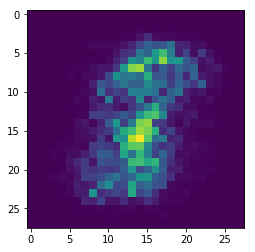

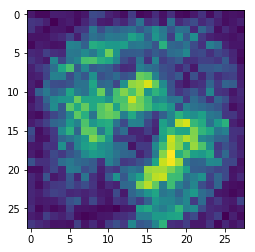

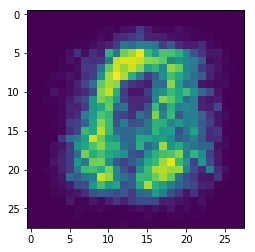

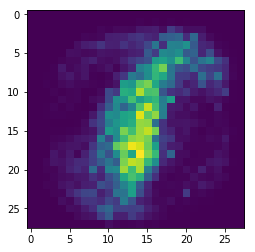

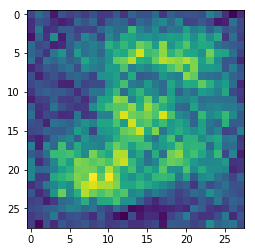

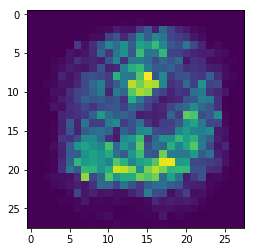

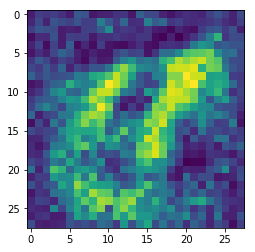

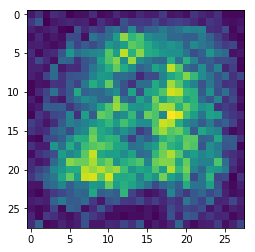

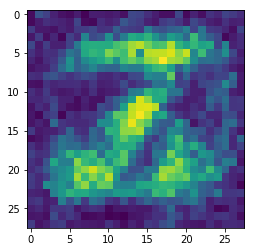

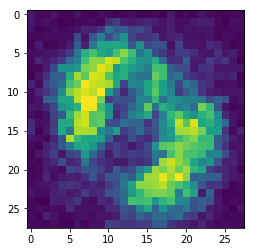

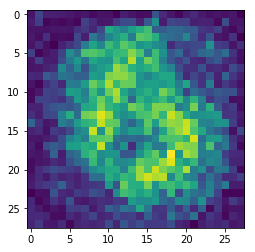

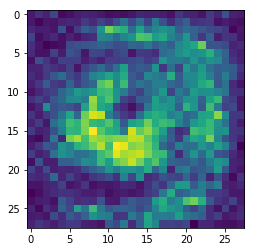

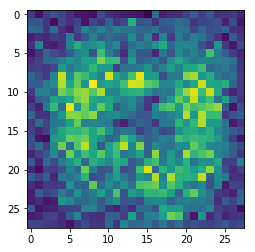

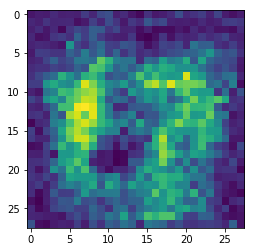

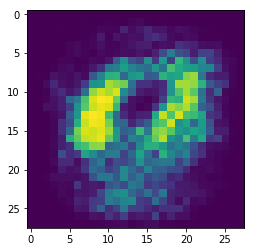

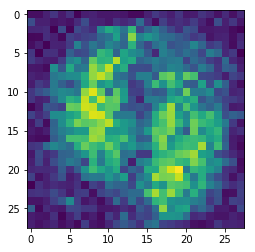

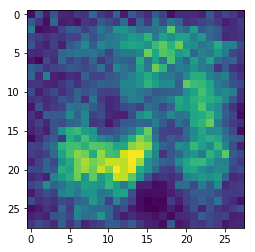

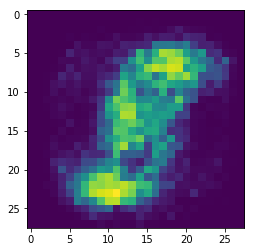

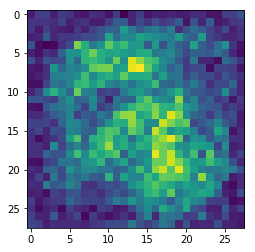

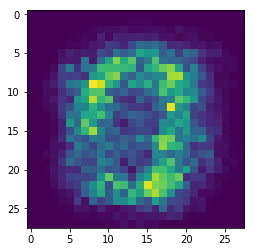

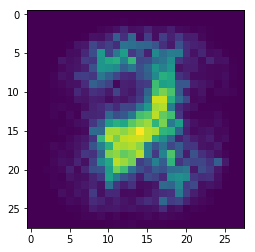

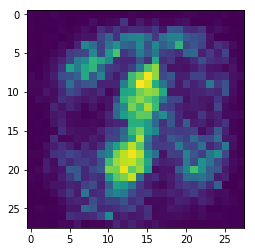

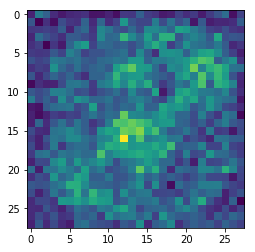

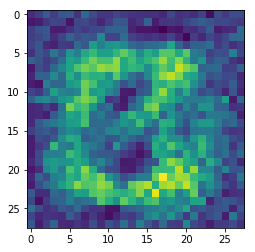

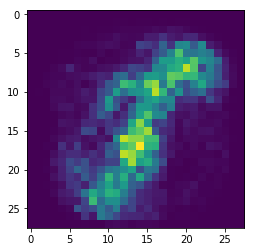

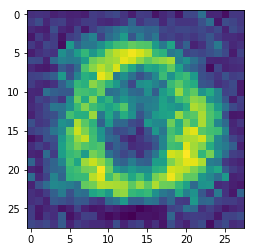

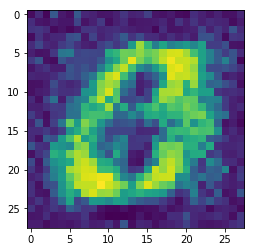

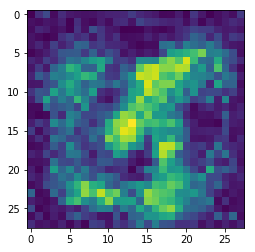

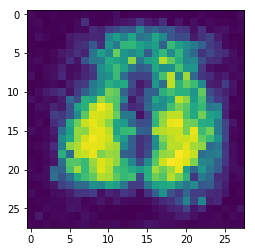

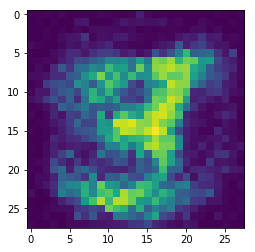

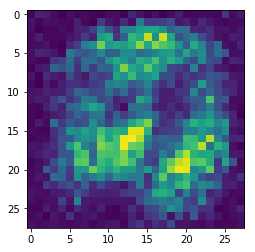

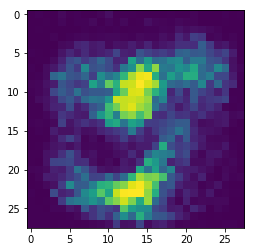

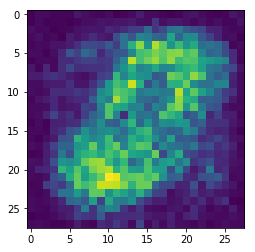

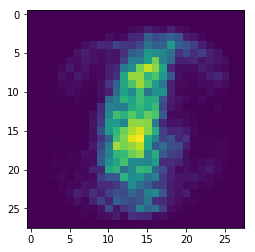

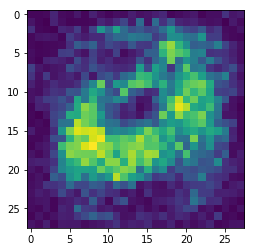

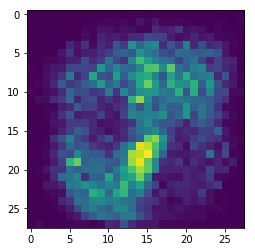

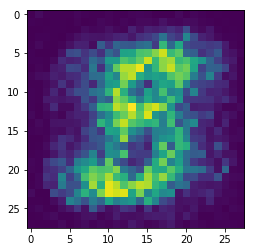

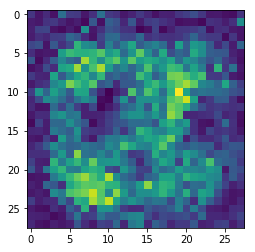

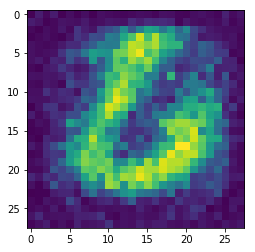

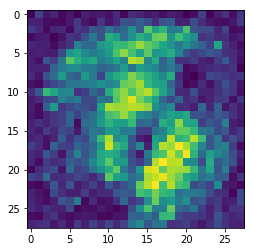

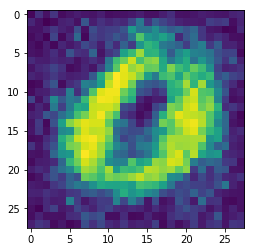

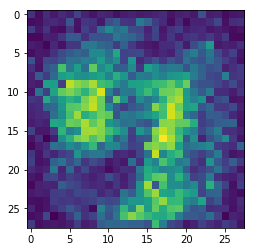

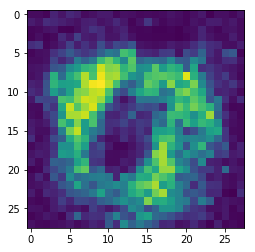

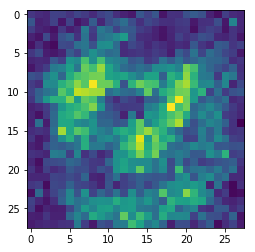

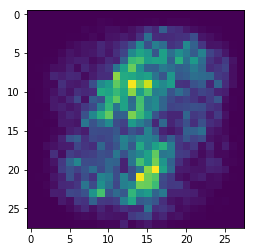

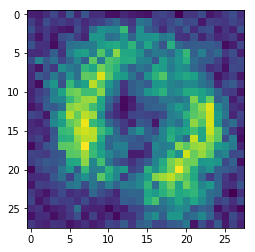

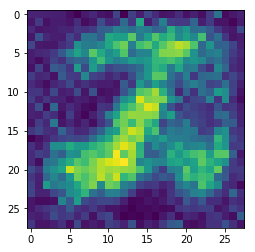

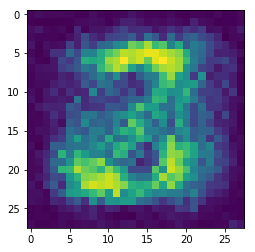

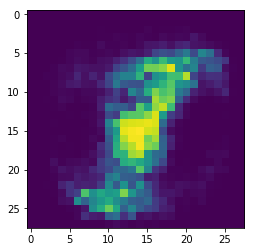

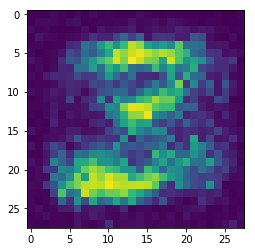

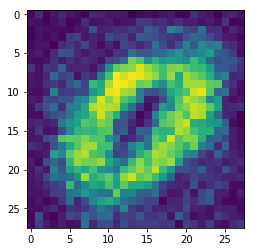

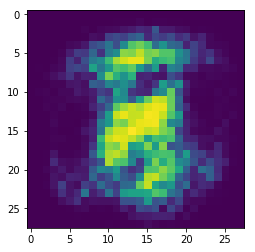

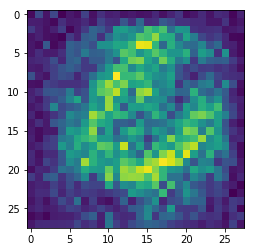

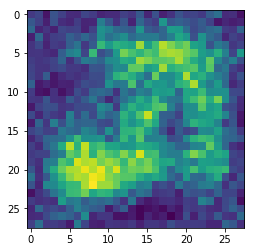

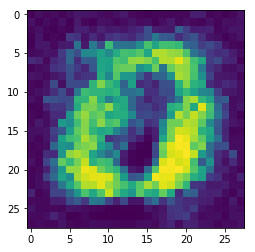

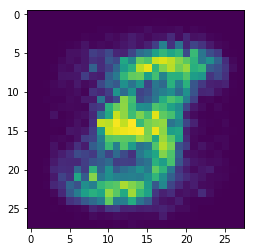

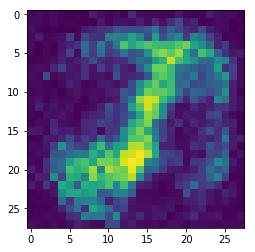

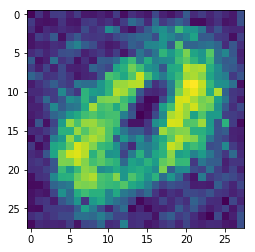

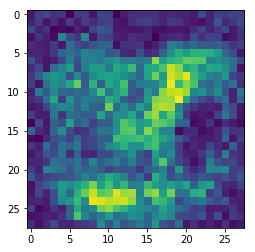

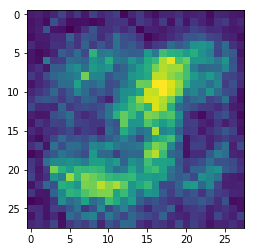

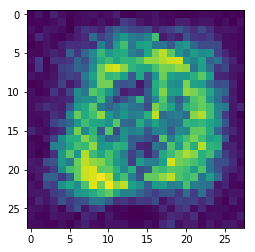

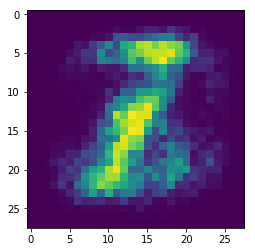

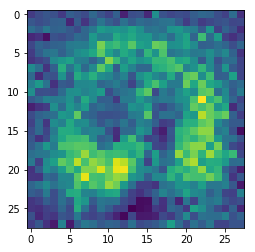

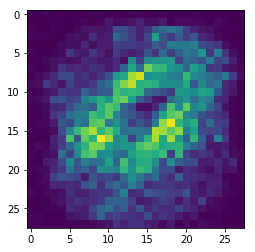

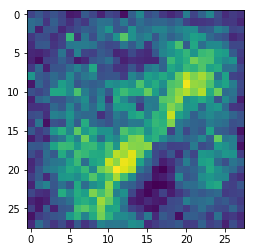

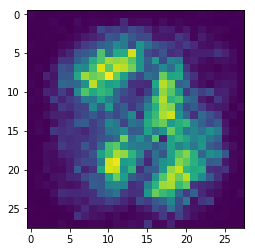

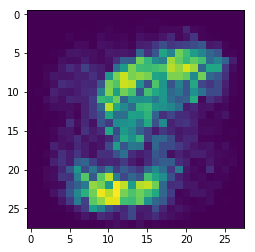

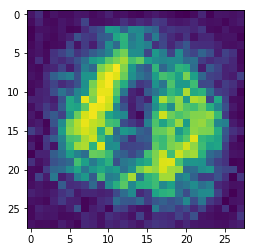

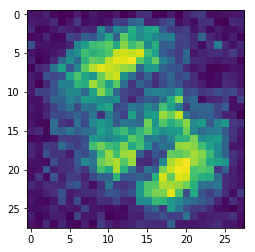

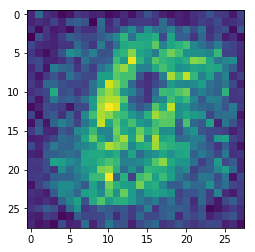

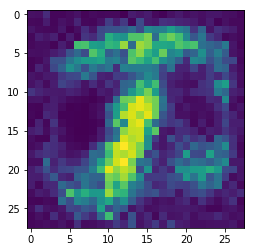

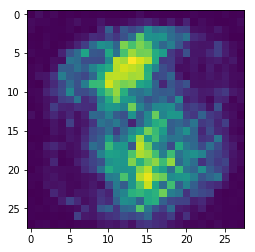

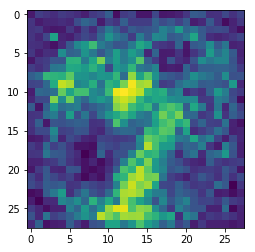

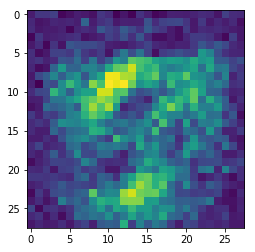

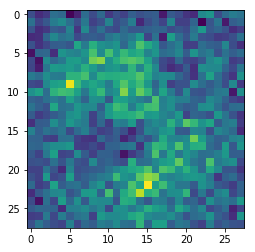

In [10]:
#reconstruction
n_pixels = 28*28
import os
load_model = False
if load_model:
    saver.restore(sess, os.path.join(os.getcwd(), "Trained Bernoulli VAE"))

# num_pairs = 10
# image_indices = np.random.randint(0, 200, num_pairs)
# for pair in range(num_pairs):
#     x = np.reshape(mnist.test.images[image_indices[pair]], (1,n_pixels))
#     y = np.random.normal(0,1,(1,256))
#     plt.figure()
#     x_image = np.reshape(x, (28,28))
#     plt.subplot(121)
#     plt.imshow(x_image)
#     x_reconstruction = output.eval(feed_dict={X: x})
#     x_reconstruction_image = (np.reshape(x_reconstruction, (28,28)))
#     plt.subplot(122)
#     plt.imshow(x_reconstruction_image)
    
for i in range(100):
    x = np.random.normal(0,1,(1,256))
    out = output.eval(feed_dict={Z:x})
    out_img = out.reshape(28,28)
    plt.imshow(out_img)
    plt.show()